# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!




# Background

We are an investment firm based in New York City to provide detailed analysis and insights to investors who are interested in investing real estate for financial growth. This project is for mid-income families or individuals with initial budget under 500K and are looking to buy in 2020. 

The areas we will be focusing on is Manhattan and Brooklyn zipcodes with average house price under 3 Million in 2016-2018. 

## KPI: 5 yr ROI (Year 5 price - Year 1 price / Year 1 price)

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [83]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [71]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [72]:
ny=df[(df['City']=='New York')]

In [73]:
area = pd.read_csv('manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [74]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')

In [75]:
ny2 = ny1[ny1['District'].notnull()]
ny2.groupby('District').count()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
District,,,,,,,,,,,,,,,,,,,,,
Brooklyn,29,29,29,29,29,29,29,25,25,25,...,29,29,29,29,29,29,29,29,29,29
Manhattan,4,4,4,4,4,4,4,1,1,1,...,4,4,4,4,4,4,4,4,4,4


Only 4 zipcodes in Manhattan are present in the database. We will focus on Brooklyn then. 

In [76]:
ny3 = ny2[ny2['District']=='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,Brooklyn
3,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,Brooklyn
9,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,Brooklyn
10,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn
11,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,Brooklyn


In [77]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')

In [78]:
ny4.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
3,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
9,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
10,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
11,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400


# Step 2: Reshape from Wide to Long Format & Data Processing

In [84]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [86]:
dfm = melt_data(ny4)

In [87]:
dfm.head()

,RegionName,Month,MeanValue
0,11226,1996-04-01,162000.0
1,11235,1996-04-01,190500.0
2,11230,1996-04-01,230100.0
3,11209,1996-04-01,255700.0
4,11212,1996-04-01,125000.0


In [88]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313 entries, 0 to 7684
Data columns (total 3 columns):
RegionName    7313 non-null int64
Month         7313 non-null datetime64[ns]
MeanValue     7313 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 228.5 KB


In [89]:
dfm.set_index('Month', inplace = True)

# Step 3: EDA and Visualization

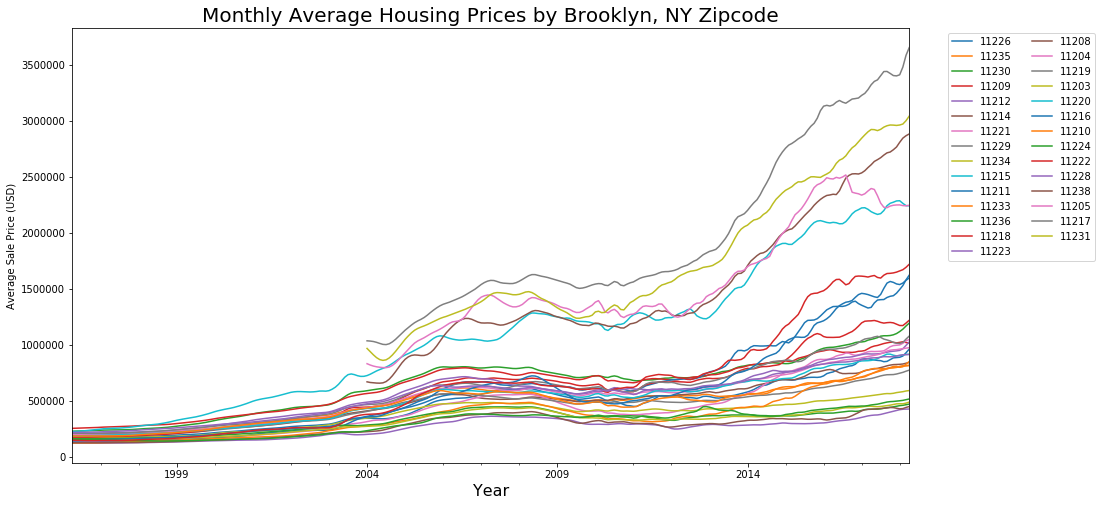

In [96]:
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


### Observations of the data:
- 25 zip codes have data from 1996 to 2018, however, 4 zip codes do not
- There was a dip in 2008 and 2010, housing price became stable around 2011.

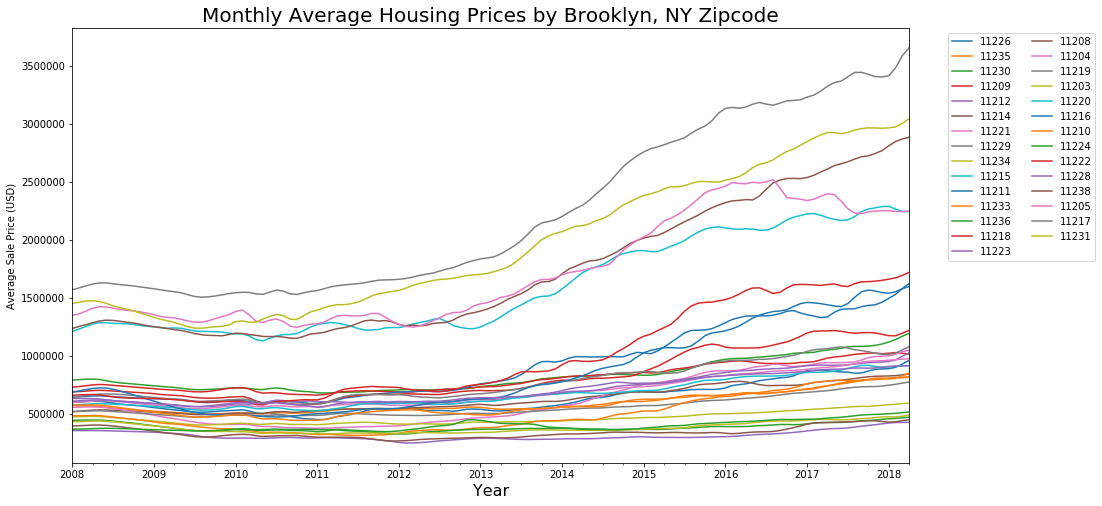

In [99]:
#A deeper look at 2008 above
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['2008':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


To get more accurate prediction on 2020 and onwards data,  we decided to use data 2011-Present. 

   # Step 4: Initial ARIMA Modeling

1. 

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results